# 1. Multinomial Logistic Regression

Logistic regression has been used in the field of biological research since the early twentieth century. Then it began to be used in many social sciences. Logistic regression is applicable when the dependent variable (target value) is categorical.

For example, we need to predict:

- whether the email is spam (1) or not (0);
- whether the tumor is malignant (1) or benign (0).

$\boldsymbol{Multinomial}$ $\boldsymbol{logistic}$ $\boldsymbol{regression}$ is a statistical method used for classification problems where the outcome can take on more than two categories. It's an extension of binary logistic regression. The goal is to model the probabilities of the different possible outcomes of a categorically distributed dependent variable, given a set of independent variables.

```{note} Let's look at the following examples:
- Classification of Texts: Determining the topic of the text (for example, sports, politics, technology, art).

- Medical Diagnosis: Classification of the type of disease (eg, infectious, inflammatory, genetic, metabolic).
```

In each of these scenarios, the outcome is multiple categories, and multinomial logistic regression can be used to predict the probability of each category.

![Alt text](https://ekababisong.org/assets/seminar_IEEE/multinomial-example.png)


##### Data Structure  
Let's imagine a data set $\mathcal D$, where each element consists of a pair of feature vectors $\boldsymbol x_i$ and a class label $y_i$:

Let $\mathcal{D}$ be a dataset defined as:

$$
\mathcal{D} = \{(\boldsymbol{x}_i, y_i)\}_{i=1}^n \quad \text{where } \boldsymbol{x}_i \in \mathbb{R}^d \text{ and } y_i \in \mathcal{Y}.
$$

Здесь $\mathcal Y$ — это множество возможных категорий.

##### Probability Prediction
Multinomial logistic regression predicts the probability of membership in each category:

The predicted probability vector $\boldsymbol{\hat{y}}$ is defined as:

$$
\boldsymbol{\hat{y}} = (p_1, \ldots, p_K), \quad \text{where } p_k > 0 \text{ and } \sum_{k=1}^K p_k = 1.
$$


##### Calculating Logits and Softmax Transformation
Logits are calculated as a linear combination of the input features and then converted to probabilities using the softmax function:

The logits $\boldsymbol{z}$ are calculated as a linear combination of the input features $\boldsymbol{x}$ and the weights $\boldsymbol{w}_k$ for each class, and the predicted probability vector $\boldsymbol{\hat{y}}$ is obtained through the softmax function:

$$
z_k = \boldsymbol{x}^\top \boldsymbol{w}_k, \quad \boldsymbol{\hat{y}} = \text{Softmax}(\boldsymbol{z}) = \left( \frac{e^{z_1}}{\sum_{k=1}^K e^{z_k}}, \ldots , \frac{e^{z_K}}{\sum_{k=1}^K e^{z_k}} \right)
$$


##### Class Selection
The predicted class is given by the argument that maximizes the probabilities:

$$
\text{Predicted class} = \arg\max_{1 \leq k \leq K} p_k
$$

##### Model parameters
The weight matrix $\boldsymbol{W}$ is defined as:

$$
\boldsymbol{W} = [\boldsymbol{w}_1 \ldots \boldsymbol{w}_K]
$$

### Quiz: Basic Concepts of Multinomial Logistic Regression


In [1]:
from jupyterquiz import display_quiz
display_quiz("quizzes/intro.json")

<IPython.core.display.Javascript object>

### Example: MNIST

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'svg'

X, Y = fetch_openml('mnist_784', return_X_y=True, parser='auto')

X = X.astype(float).values / 255
Y = Y.astype(int).values

##### Splitting into train and test

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=10000)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [4]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 970, 1144,  995,  999,  932,  910, 1017, 1050, 1013,  970]))

##### Fitting and evaluation

In [5]:
%%time
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.93
CPU times: user 19min 27s, sys: 1min, total: 20min 27s
Wall time: 2min 27s


##### Confusion matrix


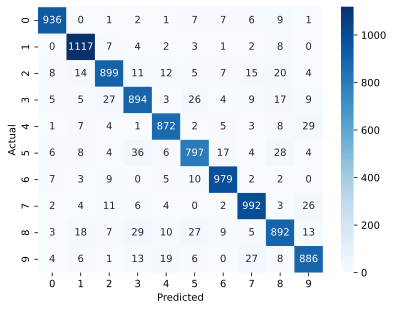

In [6]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(y_test, y_pred, model.classes_)

##### Prediction Probability Distribution for a Selected Class

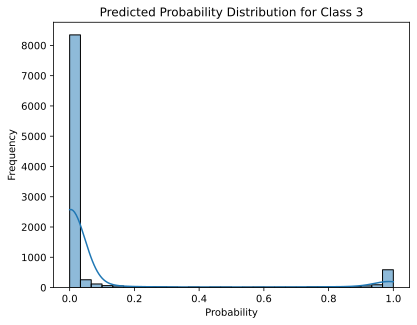

In [7]:
def plot_prediction_probabilities(model, X_test, class_idx):
    probabilities = model.predict_proba(X_test)[:, class_idx]
    sns.histplot(probabilities, kde=True, bins=30)
    plt.title(f'Predicted Probability Distribution for Class {class_idx}')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

plot_prediction_probabilities(model, X_test, class_idx=3)

##### Sample Digit Visualization

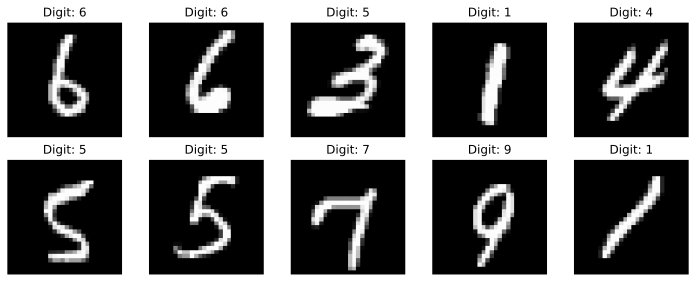

In [8]:
def plot_digits(samples, labels, n_rows=2, n_cols=5):
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(samples[i].reshape(28, 28), cmap='gray')
        plt.title(f"Digit: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_digits(X_test[:10], y_pred[:10])

#####  Feature Distribution Plot

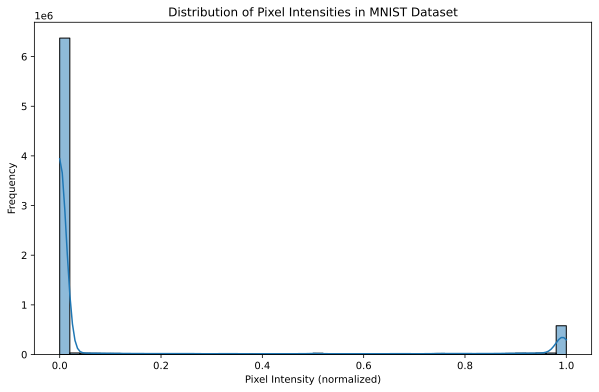

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pixel_intensity_distribution(X_test):
    # Flatten the images to get the distribution of pixel values
    pixel_values = X_test.flatten()

    # Plotting the distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(pixel_values, bins=50, kde=True)
    plt.title('Distribution of Pixel Intensities in MNIST Dataset')
    plt.xlabel('Pixel Intensity (normalized)')
    plt.ylabel('Frequency')
    plt.show()

# Call the function with the MNIST data
plot_pixel_intensity_distribution(X_test)

# 2.  Mathematical Foundations

#### Example Problem: Predicting Election Outcomes
Imagine a political analyst wants to predict the outcome of a future election based on various socioeconomic indicators. There are three political parties (A, B, and C) that voters can choose from. The analyst has collected a dataset containing previous election outcomes and corresponding indicators such as economic growth, unemployment rate, and education level.

##### Dataset Structure
The dataset $\mathcal{D}$ consists of $n$ samples with the following structure:

- Economic growth rate ($x_1$)
- Unemployment rate ($x_2$)
- Average education level ($x_3$)
- Outcome of the election (Party A, Party B, Party C)
- Each instance in the dataset is a vector $\boldsymbol{x}_i \in \mathbb{R}^3$, and the corresponding label $y_i$ is one of ${1, 2, 3}$, representing the three parties.

##### Problem Formulation
The multinomial logistic regression model can be applied to this problem to estimate the probability of each election outcome based on the socioeconomic indicators.

##### Mathematical Formulation
For a given instance $\boldsymbol{x}$, the probability that the outcome is for party $k$ is modeled as:


$$
P(y = k|\boldsymbol{x}) = \frac{\exp(\boldsymbol{x}^\top \boldsymbol{w}_k)}{\sum_{j=1}^{3} \exp(\boldsymbol{x}^\top \boldsymbol{w}_j)}
$$

Here, $\boldsymbol{w}_k$ represents the weight vector associated with party $k$, which the model will learn during training.

##### Training the Model
Using historical election data, the analyst trains a multinomial logistic regression model. The model estimates the parameters $\boldsymbol{w}_k$ for each party by maximizing the likelihood of the observed data.

##### Making Predictions
Once trained, the model can predict the probability distribution over the three parties for a new set of indicators. If a new data point has indicators $\boldsymbol{x}_{\text{new}} = [2.5%, 5%, 12 \text{ years}]$, the model will provide three probabilities corresponding to the likelihood of each party winning the election.


```{admonition} Solution
The analyst trains the model and makes predictions for a new set of indicators. The output probabilities might look something like this:

$$P(\text{Party A}|\boldsymbol{x}_{\text{new}}) = 0.70$$
$$P(\text{Party B}|\boldsymbol{x}_{\text{new}}) = 0.20$$
$$P(\text{Party C}|\boldsymbol{x}_{\text{new}}) = 0.10$$

```

#### Quiz: Mathematics-focused questions

In [10]:
from jupyterquiz import display_quiz
display_quiz("quizzes/math.json")

<IPython.core.display.Javascript object>

# 3. Data Preparation for Multinomial Logistic Regression


# 4. Model Building


# 5. Model Evaluation


# 6. Case Study: Real-world Application

Multinomial Logistic Regression (MLR) is a powerful statistical method used in various real-world scenarios where the outcome variable can take more than two categories. This versatility makes it an invaluable tool across multiple disciplines. We will explore a case study to illustrate its practical application. There are some case studies:

In [11]:
# Adjusting the HTML content for center alignment of all texts in the cards
from IPython.display import display, HTML

html_content_fully_center_aligned = """
<div style='display: grid; grid-template-columns: repeat(4, 1fr); grid-gap: 15px; padding: 10px;'>
    <div style='border: 2px solid #4CAF50; border-radius: 10px; background-color: #E8F5E9; padding: 20px; text-align: center;'>
        <h3 style='color: #388E3C;'>Case study 1</h3>
        <p style='color: #388E3C; font-weight: bold; text-align: center;'>Diagnosing Medical Conditions</p>
    </div>
    <div style='border: 2px solid #2196F3; border-radius: 10px; background-color: #E3F2FD; padding: 20px; text-align: center;'>
        <h3 style='color: #1565C0;'>Case study 2</h3>
        <p style='color: #1565C0; font-weight: bold; text-align: center;'>Customer Segmentation and Targeting</p>
    </div>
    <div style='border: 2px solid #FFC107; border-radius: 10px; background-color: #FFF8E1; padding: 20px; text-align: center;'>
        <h3 style='color: #FFA000;'>Case study 3</h3>
        <p style='color: #FFA000; font-weight: bold; text-align: center;'>Credit Risk Assessment</p>
    </div>
    <div style='border: 2px solid #FF5722; border-radius: 10px; background-color: #FBE9E7; padding: 20px; text-align: center;'>
        <h3 style='color: #D84315;'>Case study 4</h3>
        <p style='color: #D84315; font-weight: bold; text-align: center;'>Predicting Student Performance</p>
    </div>
</div>
"""

# Displaying the fully center-aligned HTML content
display(HTML(html_content_fully_center_aligned))


## Case Study 1: Diagnosing Medical Conditions

### Multinomial Logistic Regression in Medical Diagnosis

A significant application of Multinomial Logistic Regression (MLR) is in the medical field, particularly in diagnosing diseases. This case study focuses on a healthcare setting where doctors diagnose patients with one of several possible diseases based on symptoms and test results.

---

#### Data Collection

The collected data includes patient demographics, symptoms, medical history, and results from various tests. For instance, in a study on respiratory diseases, data might include symptoms like cough, fever, shortness of breath, and test results like X-rays or blood tests.

---

#### Model Development

**Dependent Variable:** The type of respiratory disease (e.g., Asthma, Bronchitis, Pneumonia, None).

**Independent Variables:** Symptoms, test results, age, gender, smoking history, etc.

The MLR model is trained on this dataset. The training process involves adjusting the model's parameters to best fit the observed data, using methods like maximum likelihood estimation.

---

#### Application in Diagnosis

Once the model is trained, it can be used in clinical settings. When a new patient arrives, their symptoms and test results are input into the model, which then predicts the probabilities of each disease. The disease with the highest probability is considered the most likely diagnosis.

---

#### Advantages

- **Accuracy:** MLR can handle multiple influencing factors, leading to more accurate diagnoses.
- **Preventive Care:** Identifying disease probabilities helps in preventive care and early intervention.

---

#### Challenges

- **Data Quality:** The accuracy of the model heavily depends on the quality and quantity of the data.
- **Complexity:** Medical data can be complex, and ensuring the model captures all relevant factors is challenging.

---

#### Results and Impact

In practice, MLR models have shown promising results in improving diagnostic accuracy. They also aid in personalized patient care by considering a wide range of individual factors. This, in turn, leads to better treatment plans and outcomes.

---



## Case Study 2: Marketing - Customer Segmentation and Targeting

### Context
In marketing, understanding customer behavior is crucial for targeted campaigns. Businesses categorize customers into different segments based on purchasing patterns, interests, and demographics.

#### Data Collection
Data includes customer demographics, purchase history, browsing behavior, and engagement with marketing campaigns.

#### Model Development
**Dependent Variable:** Customer segment (e.g., High-Spenders, Bargain Hunters, Occasional Shoppers, etc.).
**Independent Variables:** Age, income, browsing history, past purchases, and responses to previous marketing campaigns.

#### Advantages
- **Effective Targeting:** Enhances the ability to target marketing efforts more effectively.
- **Increased ROI:** Better targeting leads to higher returns on investment for marketing campaigns.

---



## Case Study 3: Financial Services - Credit Risk Assessment

### Context
Banks and financial institutions use MLR to assess the credit risk associated with lending to individuals or businesses.

#### Data Collection
Data involves credit history, repayment records, income levels, and other financial metrics.

#### Model Development
**Dependent Variable:** Risk category (e.g., Low, Medium, High risk).
**Independent Variables:** Credit score, debt-to-income ratio, employment status, etc.

#### Advantages
- **Risk Mitigation:** Helps in identifying high-risk applicants, reducing defaults.
- **Customized Lending:** Enables offering tailored interest rates based on risk profiles.

---



## Case Study 4: Education - Predicting Student Performance

### Context
Educational institutions use MLR to predict student performance and identify those who may need additional support.

#### Data Collection
Data includes previous grades, attendance records, participation in extracurricular activities, and demographic information.

#### Model Development
**Dependent Variable:** Performance category (e.g., High Achiever, Average, Below Average).
**Independent Variables:** Past academic performance, attendance, socio-economic status, etc.

#### Advantages
- **Support for Students:** Facilitates targeted support for students who might struggle.
- **Curriculum Development:** Assists in adjusting teaching methods and curriculum based on student needs.



### Example: Customer Segmentation in Marketing Using MLR
Let's say we have a customer data set that includes information about demographics, purchasing behavior, and interactions with marketing campaigns. Our goal is to predict which segment each customer belongs to (e.g., "High-Spenders", "Bargain Hunters", "Occasional Shoppers").

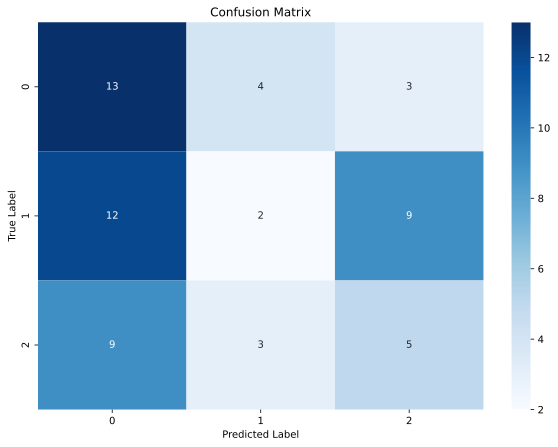

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

np.random.seed(42)
data = pd.DataFrame({
    'Age': np.random.randint(18, 65, size=200),
    'Income': np.random.randint(30000, 80000, size=200),
    'Browsing_History': np.random.randint(0, 100, size=200),
    'Past_Purchases': np.random.randint(0, 50, size=200),
    'Customer_Segment': np.random.choice(['High-Spenders', 'Bargain Hunters', 'Occasional Shoppers'], size=200)
})

features = ['Age', 'Income', 'Browsing_History', 'Past_Purchases']
target = 'Customer_Segment'

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



This code starts by generating data, then preprocesses it, trains an MLR model on that data, and finally visualizes the results of the model's predictions on a test data set. The error matrix shows how the model classifies different customer segments, which helps evaluate its effectiveness and prediction accuracy.

In [15]:
from jupyterquiz import display_quiz
display_quiz("quizzes/chapter-6-quiz.json")

<IPython.core.display.Javascript object>

# 7. Common Pitfalls and Best Practices


Multiple Linear Regression (MLR) is a powerful statistical technique used for predicting a continuous dependent variable based on two or more independent variables. While it's widely used across various fields for its simplicity and interpretability, MLR is not without its challenges.

This topic delves into the common pitfalls that practitioners often encounter when using MLR. These include overfitting, where a model is too complex for the data; underfitting, where the model is too simplistic; multicollinearity, where independent variables are highly correlated; and heteroscedasticity, where the variability of a variable is unequal across the range of values of a second variable. Each of these pitfalls can lead to inaccurate predictions and misleading conclusions if not properly addressed.

However, understanding these challenges is only half the battle. The other half lies in adopting best practices to mitigate these issues. This includes rigorous data preparation, careful model validation, the application of regularization techniques, and a focus on model interpretability. Additionally, continuous model assessment ensures that the model remains relevant and accurate over time.

In the following sections, we will explore each of these pitfalls and best practices in detail, equipping you with the knowledge to effectively use MLR in your analyses. Whether you're a seasoned statistician or a beginner in the field, understanding these aspects of MLR is crucial for developing robust and reliable models.



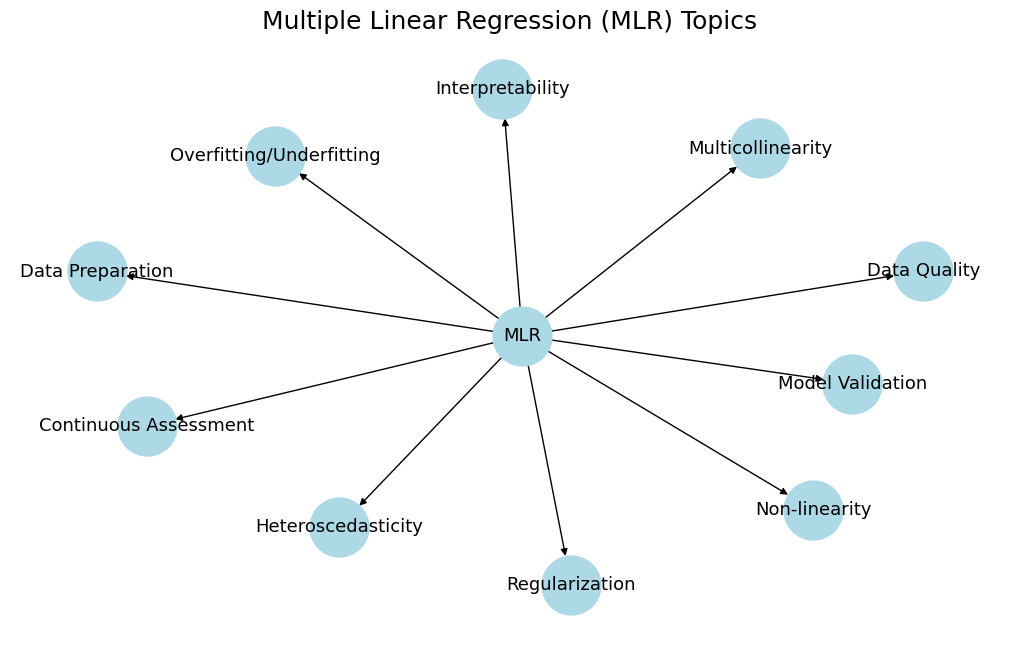

In [21]:
import matplotlib.pyplot as plt
import networkx as nx

# Creating a graph object
G = nx.DiGraph()

# Adding nodes
nodes = ["MLR", "Overfitting/Underfitting", "Multicollinearity", "Heteroscedasticity",
         "Non-linearity", "Data Quality", "Data Preparation", "Model Validation",
         "Regularization", "Interpretability", "Continuous Assessment"]
G.add_nodes_from(nodes)

# Adding edges
edges = [("MLR", "Overfitting/Underfitting"), ("MLR", "Multicollinearity"), ("MLR", "Heteroscedasticity"),
         ("MLR", "Non-linearity"), ("MLR", "Data Quality"), ("MLR", "Data Preparation"),
         ("MLR", "Model Validation"), ("MLR", "Regularization"), ("MLR", "Interpretability"),
         ("MLR", "Continuous Assessment")]
G.add_edges_from(edges)

# Adjusting the layout
pos = nx.spring_layout(G, k=0.15)  # Decreasing the 'k' value to compact the layout

# Drawing the graph
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1800, edge_color='black', linewidths=1, font_size=13)
plt.title("Multiple Linear Regression (MLR) Topics", size=18)
plt.show()


### Overfitting and Underfitting
Overfitting occurs when an MLR model captures noise in the data instead of the underlying pattern. It performs well on training data but poorly on unseen data. Underfitting, on the other hand, happens when the model is too simple to capture the complexities of the data, leading to poor performance on both training and testing sets. Avoiding these issues requires a balance - not too complex, but not overly simplistic. Techniques like cross-validation and regularizing (Lasso, Ridge) can be employed to find the right model complexity.

### Multicollinearity 
Multicollinearity in MLR refers to high correlations among independent variables, leading to unreliable and unstable coefficient estimates. This can make model interpretation difficult. Detecting multicollinearity can be done using Variance Inflation Factor (VIF) or correlation matrices. To address multicollinearity, consider removing highly correlated predictors, combining them, or using principal component analysis (PCA) for dimensionality reduction.

### Heteroscedasticity
Heteroscedasticity refers to the condition where the variance of residuals (errors) is not constant across all levels of the independent variables. This violates one of the key assumptions of MLR and can lead to inefficient estimates. Visual inspection of residual plots can help detect heteroscedasticity. Remedies include transforming the dependent variable (e.g., using log transformation) or using heteroscedasticity-consistent standard error estimators.

### Ignoring Non-linearity 
Assuming a linear relationship between variables in MLR can be misleading if the true relationship is non-linear. This ignorance can lead to poor model performance and misleading conclusions. Residual plots can be used to detect non-linearity. Addressing non-linearity might involve transforming variables, adding polynomial terms, or considering non-linear models.

### Data Quality Issues 
High-quality data is crucial for MLR. Issues like missing values, outliers, and erroneous data can significantly distort model outcomes. Effective strategies include thorough data cleaning, dealing with missing data through imputation or exclusion, and handling outliers by either removing them or using robust regression techniques.

### Proper Data Preparation 
Effective MLR begins with proper data preparation. This involves exploring data to understand its characteristics, handling missing values and outliers, and ensuring that variables are appropriately scaled or transformed. Data preparation sets the stage for a more reliable and interpretable model.

### Model Validation Techniques 
Model validation is crucial to ensure that an MLR model generalizes well to new data. Techniques like the train-test split and k-fold cross-validation help in assessing model performance reliably. These methods provide a more accurate understanding of how the model will perform in real-world scenarios.

### Regularization Techniques
Regularization techniques such as Lasso, Ridge, and Elastic Net help prevent overfitting in MLR by penalizing large coefficients. These techniques are particularly useful when dealing with high-dimensional data or when multicollinearity is present. They help in selecting more significant features and improving model interpretability.



### Model Interpretability 
Interpretability is key in MLR. It involves understanding how the model makes predictions and explaining these in a meaningful way. Clear interpretation of coefficients, understanding the influence of each predictor, and communicating these findings in a non-technical manner are essential aspects of model interpretability.

### Continuous Model Assessment 
Continuous assessment of an MLR model ensures its relevance over time. This involves regularly updating the model with new data, monitoring its performance, and making adjustments as necessary. This ongoing process helps in maintaining the accuracy and reliability of the model in changing conditions.



Each of these articles offers a focused overview of a specific aspect of MLR, providing valuable insights into both the challenges and effective strategies in the field of linear regression modeling.

In [17]:
from jupyterquiz import display_quiz
display_quiz("quizzes/chapter-7-quiz.json")

<IPython.core.display.Javascript object>

# 8. Interactive Exercises


In [38]:
# Define the plotting function
def plot_results(X_pca, y_true, y_pred):
    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=('True Labels', 'Predicted Labels'))

    # Add scatter plots
    fig.add_trace(go.Scatter(x=X_pca[:, 0], y=X_pca[:, 1], mode='markers',
                             marker=dict(color=y_true, size=5, colorscale='Viridis', showscale=True),
                             name='True Label'), row=1, col=1)
    fig.add_trace(go.Scatter(x=X_pca[:, 0], y=X_pca[:, 1], mode='markers',
                             marker=dict(color=y_pred, size=5, colorscale='Viridis', showscale=True),
                             name='Predicted Label'), row=1, col=2)

    # Update layout
    fig.update_layout(height=400, width=1200, title_text="PCA of MNIST Data")
    
    # Show figure
    fig.show()

In [39]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import ipywidgets as widgets

# Load and normalize MNIST data
X, Y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
X = X / 255.0
Y = Y.astype(int)

# Subsample the data for quicker processing
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, _ in sss.split(X, Y):
    X_sub, Y_sub = X[train_index], Y[train_index]

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.80)
X_pca = pca.fit_transform(X_sub)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_sub, test_size=0.2, random_state=42)

# Define the training and evaluation function
def train_and_evaluate(C, max_iter, solver):
    # Create logistic regression model
    model = LogisticRegression(C=C, max_iter=max_iter, solver=solver, multi_class='multinomial')
    # Fit the model
    model.fit(X_train, y_train)
    # Predict the classes
    y_pred = model.predict(X_test)
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model trained with C={C}, max_iter={max_iter}, solver='{solver}'")
    print(f"Model Accuracy: {accuracy:.2f}")

    # Call the plot_results function
    plot_results(X_test, y_test, y_pred)

# Create interactive widgets for model parameters
C_slider = widgets.FloatLogSlider(value=1.0, base=10, min=-4, max=4, step=0.1, description='C (Regularization strength):')
max_iter_slider = widgets.IntSlider(value=1000, min=100, max=2000, step=100, description='Max Iterations:')
solver_dropdown = widgets.Dropdown(options=['lbfgs', 'saga'], value='lbfgs', description='Solver:')

# Display the widgets and link to the train_and_evaluate function
interactive_plot = widgets.interactive(train_and_evaluate, C=C_slider, max_iter=max_iter_slider, solver=solver_dropdown)
display(interactive_plot)

ModuleNotFoundError: No module named 'plotly'

# 9. Conclusion and Further Resources
